## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
train_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2014')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs = (asos_snotel_UA_df.index >= '01-01-2014') & (asos_snotel_UA_df.index < '01-01-2015')

test = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-02-2006')
print(asos_snotel_UA_df['KGJT_d300_200_height_m'][test])

Date_Time
2006-01-01 00:00:00+00:00   -2630.0
2006-01-01 12:00:00+00:00   -2700.0
Name: KGJT_d300_200_height_m, dtype: float64


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        


        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    



Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

In [6]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


#df_sfc = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                           'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()
#
#df = asos_snotel_UA_df[df = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                        'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', \
#                        'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', \
#                        'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', \
#                        'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
#                        'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', \
#                        'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', \
#                        'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
#                        'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', \
#                         'KGJT_d250_200_speed_kts','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()

good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

print(test_train_df)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

In [7]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
train_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2014')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt = (test_train_df.index >= '01-01-2014') & (test_train_df.index < '01-01-2015')



### Now run OLS model with the chosen variables ##

In [8]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.21258718699801626
KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.21258718699801615
KGJT_d700_300_drct+ KGJT_d

KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.2017055267655451
CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d50

KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.18738462039055137
KGJT_d850_250_height_m+ 

KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KG

KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwp

KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_

KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250

KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d70

KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_70

KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT

KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_

KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_he

KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_h

KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_k

KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_hei

KGJT_d400_300_tmpc+ KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500m

KGJT_d400_200_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ K

KGJT_d500_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_

**Create plot of adjusted R squared**

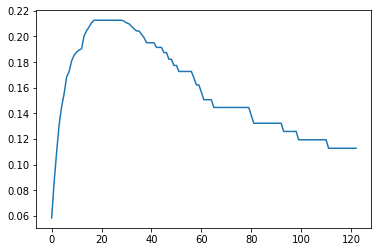

In [9]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

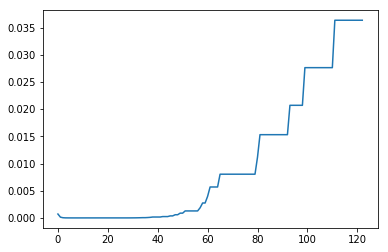

In [10]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [11]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 CMtn_Dewpoint_degC 
 Adjusted R: 0.05846074932092893  Fstat(prob): 0.0007164770060356683

1 KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.08667611656797347  Fstat(prob): 0.0001452924919196073

2 KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.10994893199071809  Fstat(prob): 3.897271473633432e-05

3 KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.13135286590000372  Fstat(prob): 1.1387304097960041e-05

4 KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.14521137870048362  Fstat(prob): 6.290713965163625e-06

5 CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.15548570130377093  Fstat(prob): 4.597171220605891e-06

6 KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted

27 KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.21258718699801604  Fstat(prob): 5.6771273187242365e-06

28 KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_sp


39 KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.19505580453024207  Fstat(prob): 0.0001674321650331065

40 KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_

49 KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_50

57 LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_

65 KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d500_300_drct+ KGJT_d700_300_drct+ KGJT_d400_250_drct+ KGJT_300mb_drct+ KGJT_700mb_drct+ KGJT_d300_250_dwpc+ KGJT_d700_250_dr

72 KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_height_m+ KGJT_d500_250_drct+ KGJT_d500_400_

77 KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_speed_kts+ KGJT_700mb_dwpc+ KGJT_d700_400_dwpc+ KGJT_500mb_tmpc+ KGJT_d700_400_he

83 KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_700mb_tmpc+ KGJT_d7

88 KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_500mb_dwpc+ KGJT

93 KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_d300_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m

97 KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_200_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d300_200_height_m+ KGJT_d

101 KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC+ KGJT_400mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_d850_500_height_m+ KGJT_d250_20

105 KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_400mb_speed_kts+ LXV_Dewpoint_degC

109 KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT_d700_500_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_

113 KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_300mb_height_m+ KGJT_d850_700_height_m+ KGJT_500mb_height_m+ KGJT

117 KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d500_400_height_m+ KGJT_850mb_height_m+ KGJT_d700_300_hei

121 KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_250_tmpc+ KGJT_250mb_tmpc+ KGJT_200mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d400_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_d500_200_dwpc+ LXV_WindDirection_deg+ KGJT_d400_300_height_m+ KGJT_d700_200_height_m+ KGJT_250mb_height_m+ KGJT_d850_400_height_m+ KGJT_d700_250_height_m+ KGJT_d

**Find max adj R and obtain OLS summary**

In [12]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC


In [13]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.294
Model:                                               OLS   Adj. R-squared:                  0.213
Method:                                    Least Squares   F-statistic:                     3.625
Date:                                   Sat, 20 Apr 2019   Prob (F-statistic):           5.68e-06
Time:                                           20:36:50   Log-Likelihood:                -340.62
No. Obser

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [14]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str,test_train_df[train_yrs_tt]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str,test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())


KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
1
KGJT_d700_250_drct+ KGJT_d300_250_drct+ KGJT_250mb_drct+ KGJT_d700_500_drct 0.04531595706969882 0.01
0.04531595706969882 0.01
2
KGJT_d700_250_drct+ KGJT_d700_400_tmpc+ KGJT_d300_250_drct+ KGJT_250mb_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.1257423988119215 0.02
0.1257423988119215 0.02
3
KGJT_d700_250_drct+ KGJT_d700_400_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_250mb_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.1342615535135171 0.03
0.1342615535135171 0.03
4
KGJT_d700_250_drct+ KGJT_d700_400_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_250mb_drct+ KGJT_400mb

KGJT_d700_250_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21936222005406603 0.27
28
KGJT_d700_250_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21936222005406603 0.28
29
KGJT_d700_250_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ 

KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21936222005406603 0.48
49
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21936222005406603 0.49
50
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d300

KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21258718699801626 0.6900000000000001
70
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21258718699801626 0.7000000000000001
71
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_20

KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21258718699801626 0.88
89
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_dwpc+ KGJT_700mb_speed_kts+ KGJT_500mb_drct+ KGJT_d250_200_tmpc+ KGJT_d500_200_height_m+ KGJT_d300_250_drct+ CMtn_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_250mb_drct+ KGJT_400mb_dwpc+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.21258718699801626 0.89
90
KGJT_d700_250_drct+ KGJT_d400_300_drct+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ KGJT_400mb_drct+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ 

strong multicollinearity problems or that the design matrix is singular.


In [15]:
import csv
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict_snf = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])

rows = zip(actual_snf, predict_snf)

with open('C:/Users/RAPP/Documents/Capstone/Projects/OLS_UASFC_2014Train.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

**No improvement to P|t| could be made**